In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [2]:
import pickle
import os

def load_cifar10_batch(batch_file):
    """Load a single batch of CIFAR-10."""
    with open(batch_file, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
        data = batch['data']
        labels = batch['labels']
        data = data.reshape((len(data), 3, 32, 32))
        data = data.transpose(0, 2, 3, 1)  # Chuyển từ (N, 3, 32, 32) sang (N, 32, 32, 3)
    return data, labels

def load_cifar10(data_dir):
    """Load all of CIFAR-10."""
    train_data = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, 'data_batch_{}'.format(i))
        data, labels = load_cifar10_batch(batch_file)
        train_data.append(data)
        train_labels.append(labels)

    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)

    test_data, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))

    return train_data, train_labels, test_data, test_labels

# Đường dẫn tới thư mục chứa các tệp CIFAR-10 đã giải nén
data_dir = 'cifar-10-python\cifar-10-batches-py'

# Đọc dữ liệu
train_data, train_labels, test_data, test_labels = load_cifar10(data_dir)

test_labels = np.array(test_labels)

print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)
print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)


Train data shape: (50000, 32, 32, 3)
Train labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


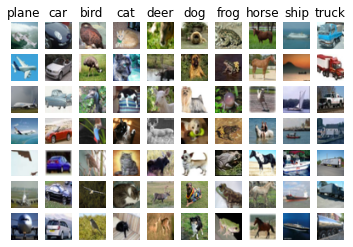

In [3]:
import matplotlib.pyplot as plt

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_data[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
num_training = 47000
num_validation = 3000



mask = range(num_training, num_training + num_validation)
Val_data = train_data[mask]
Val_labels = train_labels[mask]

mask = range(num_training)
Train_data = train_data[mask]
Train_labels = train_labels[mask]

In [5]:
import cv2

def compute_hog_features(images):
    hog_features_list = []
    hog_descriptor = cv2.HOGDescriptor(
        _winSize=(32 // 8 * 8, 32 // 8 * 8),
        _blockSize=(16, 16),
        _blockStride=(8, 8),
        _cellSize=(8, 8),
        _nbins=9
    )

    for image in images:
        # Chuyển đổi ảnh RGB sang grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Tính toán HOG đặc trưng
        hog_features = hog_descriptor.compute(gray_image)
        hog_features_list.append(hog_features.flatten())
    
    hog_features_array = np.array(hog_features_list)
    return hog_features_array

In [6]:
X_train = Train_data
y_train = Train_labels
X_val = Val_data
y_val = Val_labels
X_test = test_data
y_test = test_labels

In [7]:
def Train(X_train, y_train, C, kernel):
    X_train = compute_hog_features(X_train)
    
    svc = svm.SVC(probability=False,  kernel=kernel, C=C)
    svc.fit(X_train, y_train)
    
    return svc

In [13]:
def predict(X_test, svc):
    X_test = compute_hog_features(X_test)
    
    y_pred = svc.predict(X_test)
    
    return np.array(y_pred)

In [9]:
svc = Train(X_train, y_train, C=0.1, kernel="linear")

In [14]:
y_pred = predict(X_test, svc)

In [16]:
y_pred

array([3, 8, 1, ..., 5, 1, 7])

In [17]:
y_test = np.array(y_test)
acc_train = np.mean(y_pred == y_test)
print('Train Accuracy = {0:f}'.format(acc_train))

Train Accuracy = 0.534500


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.60      0.59      1000
           1       0.64      0.65      0.64      1000
           2       0.45      0.37      0.40      1000
           3       0.38      0.30      0.33      1000
           4       0.42      0.50      0.46      1000
           5       0.46      0.43      0.45      1000
           6       0.52      0.66      0.58      1000
           7       0.59      0.56      0.57      1000
           8       0.60      0.63      0.61      1000
           9       0.68      0.65      0.66      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000

